In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.nn as nn
import pandas as pd
import seaborn as sns

In [2]:
import os

In [ ]:
! conda install -y gdown

!gdown --id 1fOCHmxc1MrXc-AHnvcqYvHu0y9LupOhV
!gdown --id 1vkTHZqjYynj0-eymcFkPND4GvJvyd8BE
!unzip -u ./test.zip -d ./test 
!unzip -u ./train.zip -d ./train 

In [8]:
train='./train'
test='./test'

classes = os.listdir(test) 
print(classes)

def totalSize(path):
    sum = 0;
    for path, subdirs, files in os.walk(path):  ## walk directory    
        sum += len(files)
    return sum

print("Train Number Of Images : ",totalSize(train))
print("Test Number Of Images : ",totalSize(test))

['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
Train Number Of Images :  2870
Test Number Of Images :  394


In [10]:
BATCH_SIZE = 16  
IMAGE_SIZE = 180 

transform = transforms.Compose([

                                # torchvision.transforms.ColorJitter(brightness=0.4),
#                                 transforms.RandomRotation(20,expand=True), 
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                
                               ])
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train,transform=transform),
    batch_size=16, shuffle=True
)

# transform2 = transforms.Compose([
                                
#                                 transforms.Resize(IMAGE_SIZE),  ## image resize
#                                 transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                                ])

test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test,transform=transform),
    batch_size=BATCH_SIZE, shuffle=True
)

In [11]:
# from torch.optim.lr_scheduler import StepLR
import torchvision.models as models

inception_v3= models.inception_v3(pretrained=True,aux_logits=False) 

# inception_v3.cuda()

num_classes =4
batch_size = 16

learning_rate=0.0001

optimizer = torch.optim.Adam(inception_v3.parameters(),lr=learning_rate)

# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
 
criterion = torch.nn.CrossEntropyLoss()

inception_v3.fc = nn.Linear(2048, 4)
inception_v3.cuda()
print("Model Is Ready To Run ")

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Model Is Ready To Run 


In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
PATH='./inception.pth'

training_losses = []
training_accuracy = []
validation_losses = []
validation_accuracy = []
totalsteps = []
epochs = 10
steps = 0
running_loss = 0
print_every = 1

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        inception_v3.train()
        
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
        
        logps = inception_v3.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward() # computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation
        optimizer.step() # the optimizer to take a step based on the gradients of the parameters.
 
        #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
       
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            validation_loss = 0
            accuracy = 0
            inception_v3.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = inception_v3.forward(inputs)
                    batch_loss = criterion(logps, labels)                    
                    validation_loss += batch_loss.item()
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            training_losses.append(running_loss/print_every)
            training_accuracy.append(after_train_accuracy)
            validation_losses.append(validation_loss/len(test_loader))
            validation_accuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Step {steps} "
                  f"Train loss: {running_loss/print_every:f} "
                  f"Train accuracy: {after_train_accuracy:f} "
                  f"Validation loss: {validation_loss/len(test_loader):f} "
                  f"Validation accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            inception_v3.train()
print('Finish Train')
torch.save(inception_v3.state_dict(), PATH)

Device cuda Epoch 1/10 Step 1 Train loss: 1.290272 Train accuracy: 0.437500 Validation loss: 1.388510 Validation accuracy: 0.256500
Device cuda Epoch 1/10 Step 2 Train loss: 1.460344 Train accuracy: 0.125000 Validation loss: 1.381666 Validation accuracy: 0.285500
Device cuda Epoch 1/10 Step 3 Train loss: 1.479017 Train accuracy: 0.250000 Validation loss: 1.380513 Validation accuracy: 0.295500
Device cuda Epoch 1/10 Step 4 Train loss: 1.342297 Train accuracy: 0.375000 Validation loss: 1.373681 Validation accuracy: 0.340000
Device cuda Epoch 1/10 Step 5 Train loss: 1.392547 Train accuracy: 0.187500 Validation loss: 1.379155 Validation accuracy: 0.302000
Device cuda Epoch 1/10 Step 6 Train loss: 1.243080 Train accuracy: 0.625000 Validation loss: 1.382952 Validation accuracy: 0.295500
Device cuda Epoch 1/10 Step 7 Train loss: 1.270422 Train accuracy: 0.562500 Validation loss: 1.377300 Validation accuracy: 0.310000
Device cuda Epoch 1/10 Step 8 Train loss: 1.170312 Train accuracy: 0.500000 

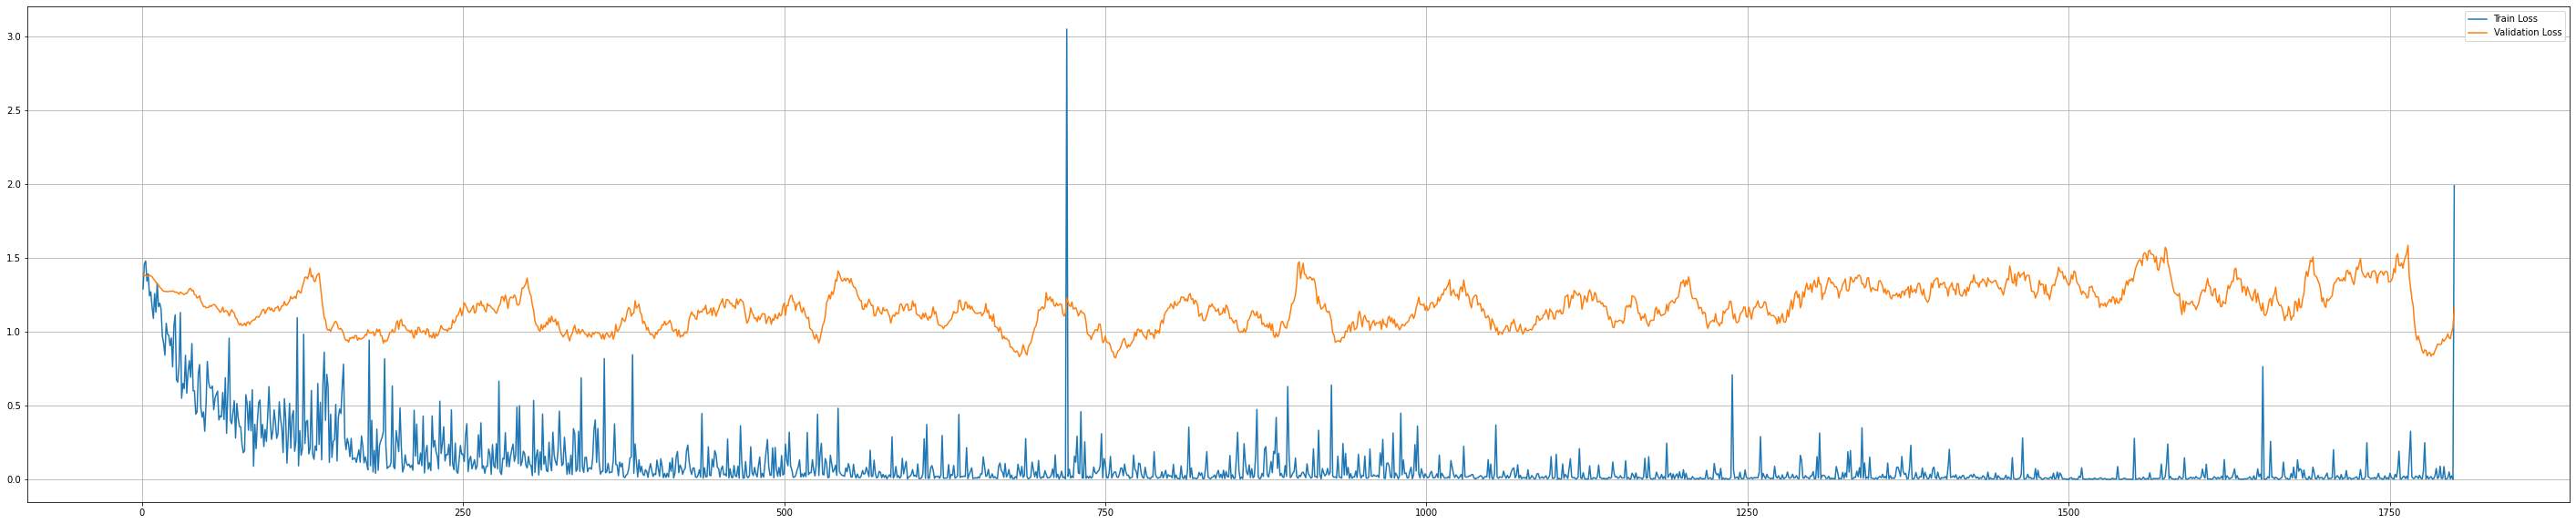

In [14]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(totalsteps, training_losses, label='Train Loss')
plt.plot(totalsteps, validation_losses, label='Validation Loss')
plt.legend()
plt.grid()
plt.show()

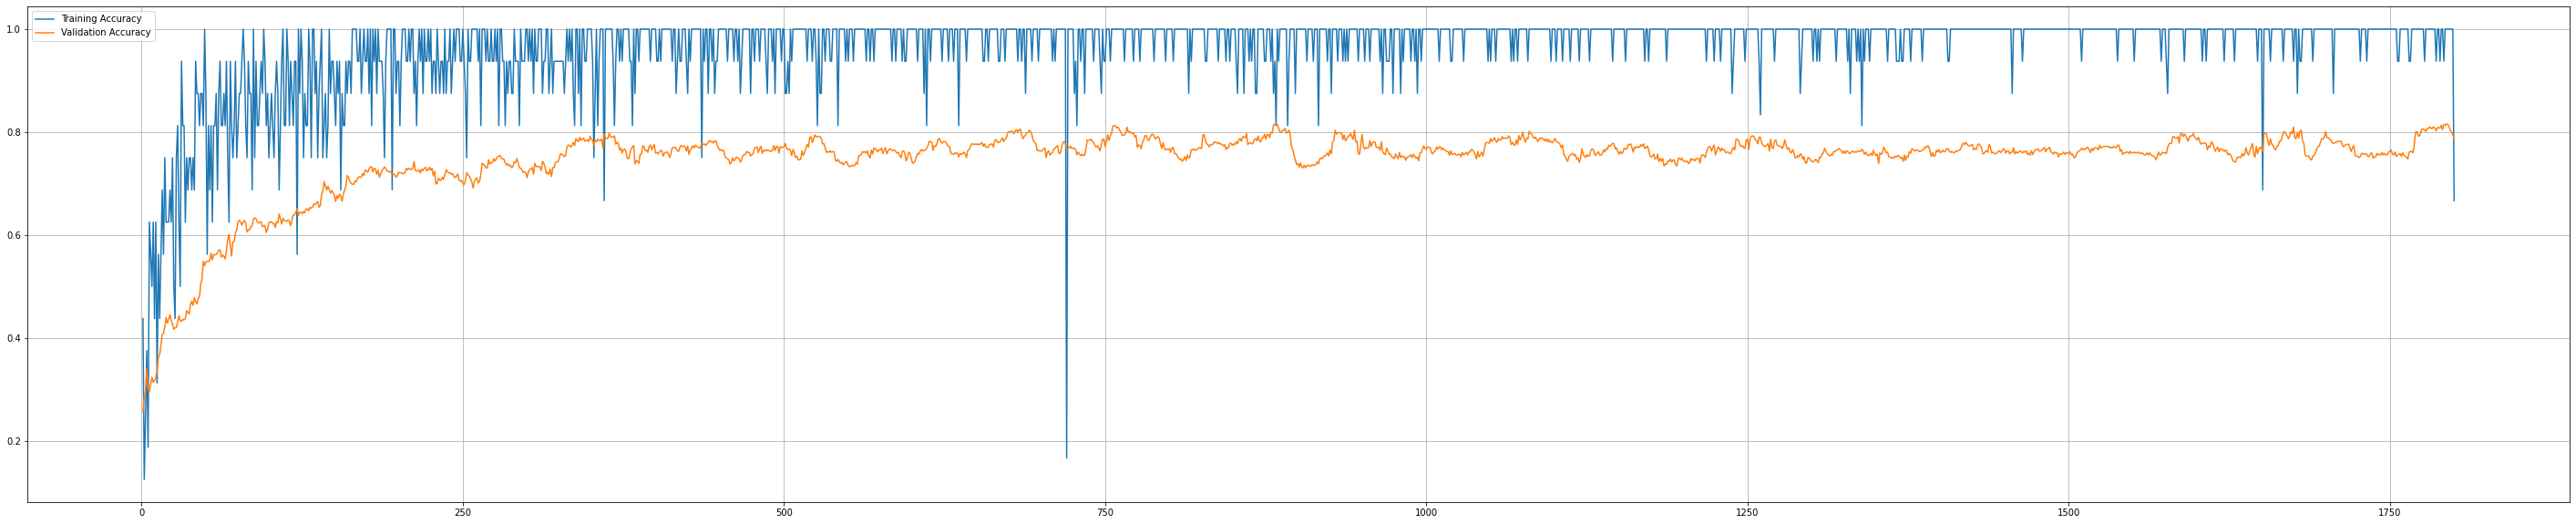

In [15]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(totalsteps, training_accuracy, label='Training Accuracy')
plt.plot(totalsteps, validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [16]:
total = 0
correct=0
with torch.no_grad():
    inception_v3.eval()
    for inputs, labels in test_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = inception_v3(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(total)
print(correct) 

print('Accuracy of the network  test images: %d %%' % (100 * correct / total))

394
310
Accuracy of the network on the 3200 test images: 78 %


In [17]:
y_true_tensor = torch.tensor([]).cuda()
y_pred_tensor = torch.tensor([]).cuda()

inception_v3.eval()
for i,(inputs, labels) in enumerate(test_loader):

  inputs, labels = inputs.to(device), labels.to(device)
  outputs = inception_v3(inputs)
  _, preds = torch.max(outputs, 1)
  y_true_tensor = torch.cat((y_true_tensor,labels))
  y_pred_tensor = torch.cat((y_pred_tensor,preds))
  print(i)
  # break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [19]:
y_true = y_true_tensor.tolist()
y_pred = y_pred_tensor.tolist()

In [20]:
matrix = confusion_matrix(y_true,y_pred)
matrix

array([[ 22,  47,  21,  10],
       [  0, 115,   0,   0],
       [  0,   0, 105,   0],
       [  0,   0,   6,  68]])

In [22]:
test_set = torchvision.datasets.ImageFolder(test, transform=transform2)


In [23]:
target_names = list(test_set.class_to_idx.keys())

In [24]:
classify_report = classification_report(y_true, y_pred, target_names=target_names)
print(classify_report)

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.22      0.36       100
meningioma_tumor       0.71      1.00      0.83       115
        no_tumor       0.80      1.00      0.89       105
 pituitary_tumor       0.87      0.92      0.89        74

        accuracy                           0.79       394
       macro avg       0.84      0.78      0.74       394
    weighted avg       0.84      0.79      0.74       394



Text(0.5, 14.09375, 'Predicted label')

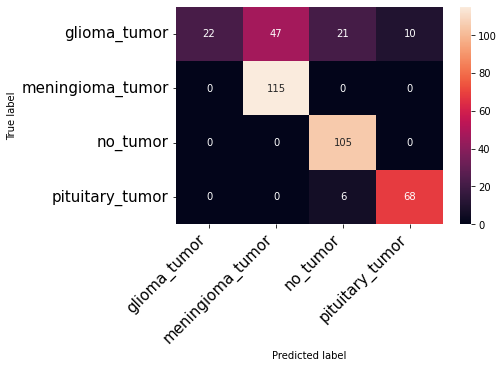

In [25]:
import pandas as pd
import seaborn as sns
df_cm = pd.DataFrame(matrix, index=target_names, columns=target_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')